In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
def train_model(model, dataloader, criterion, optimizer, iteration, epochs=5):
    model.train()
    accuracies = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Evaluar en cada época para registrar todas las accuracies
        accuracy = evaluate_model(model, test_loader)
        accuracies.append(accuracy)

    print(f'Accuracy: {max(accuracies):.2%}')
    return total_loss / len(dataloader), accuracies

In [4]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    return correct / total

In [5]:
def create_prune_mask(model, prune_percentage=0.2):
    mask = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            threshold = torch.quantile(param.abs(), prune_percentage)
            mask[name] = (param.abs() > threshold).float().to(device)
    return mask

def prune_model(model, mask):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in mask:
                param.data *= mask[name]

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 5
iterations = 10

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
results = {}

model = SimpleMLP().to(device)
model_entrenado = SimpleMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_inicial = model.state_dict()
prune_percentages = [80, 70, 60, 50, 40, 30, 20, 15, 10, 8, 5, 3]
iterations = 5

def run_experiment():
    global results
    print(f"===== Modelo original =====")
    _, accuracies_original = train_model(model, train_loader, criterion, optimizer, 0, epochs)

    print(f"Final accuracies for original model: {accuracies_original}")
    results[100] = {
        "accuracies": accuracies_original
    }
    
    for prune_percentage in prune_percentages:
        model.load_state_dict(model_inicial)
        print(f"===== Pruning al {prune_percentage}% =====")

        accuracies_pruned = []
        for iteration in range(1, iterations + 1):
            print(f"Iteración {iteration}/{iterations}")

            prune_mask = create_prune_mask(model_entrenado, prune_percentage / 100.0)
            prune_model(model, prune_mask)

            _, accuracies = train_model(model, train_loader, criterion, optimizer, iteration, epochs)
            accuracies_pruned.extend(accuracies)

        results[prune_percentage] = {
            "accuracies": accuracies_pruned
        }

        print(f"Final accuracies for pruning at {prune_percentage}%: {accuracies_pruned}")

run_experiment()

===== Modelo original =====
Accuracy: 97.83%
Final accuracies for original model: [0.9601, 0.9712, 0.9783, 0.9757, 0.9769]
===== Pruning al 80% =====
Iteración 1/5
Accuracy: 98.03%
Iteración 2/5
Accuracy: 98.07%
Iteración 3/5
Accuracy: 98.19%
Iteración 4/5
Accuracy: 98.15%
Iteración 5/5
Accuracy: 97.95%
Final accuracies for pruning at 80%: [0.9749, 0.9784, 0.9779, 0.9803, 0.9791, 0.9746, 0.9771, 0.9804, 0.9807, 0.9782, 0.979, 0.9782, 0.9748, 0.9819, 0.9796, 0.9761, 0.9777, 0.9772, 0.9815, 0.9778, 0.978, 0.9775, 0.9779, 0.9781, 0.9795]
===== Pruning al 70% =====
Iteración 1/5
Accuracy: 97.99%
Iteración 2/5
Accuracy: 98.18%
Iteración 3/5
Accuracy: 98.12%
Iteración 4/5
Accuracy: 98.04%
Iteración 5/5
Accuracy: 97.98%
Final accuracies for pruning at 70%: [0.9799, 0.9791, 0.9763, 0.9771, 0.9784, 0.9783, 0.9805, 0.9758, 0.9808, 0.9818, 0.9781, 0.9746, 0.974, 0.98, 0.9812, 0.9744, 0.9793, 0.978, 0.9797, 0.9804, 0.9781, 0.9798, 0.9788, 0.9776, 0.9758]
===== Pruning al 60% =====
Iteración 1/5
Ac

In [8]:
results

{100: {'accuracies': [0.9601, 0.9712, 0.9783, 0.9757, 0.9769]},
 80: {'accuracies': [0.9749,
   0.9784,
   0.9779,
   0.9803,
   0.9791,
   0.9746,
   0.9771,
   0.9804,
   0.9807,
   0.9782,
   0.979,
   0.9782,
   0.9748,
   0.9819,
   0.9796,
   0.9761,
   0.9777,
   0.9772,
   0.9815,
   0.9778,
   0.978,
   0.9775,
   0.9779,
   0.9781,
   0.9795]},
 70: {'accuracies': [0.9799,
   0.9791,
   0.9763,
   0.9771,
   0.9784,
   0.9783,
   0.9805,
   0.9758,
   0.9808,
   0.9818,
   0.9781,
   0.9746,
   0.974,
   0.98,
   0.9812,
   0.9744,
   0.9793,
   0.978,
   0.9797,
   0.9804,
   0.9781,
   0.9798,
   0.9788,
   0.9776,
   0.9758]},
 60: {'accuracies': [0.9787,
   0.978,
   0.979,
   0.9822,
   0.9791,
   0.9776,
   0.9788,
   0.9806,
   0.9791,
   0.978,
   0.9819,
   0.9766,
   0.9784,
   0.9783,
   0.9803,
   0.9812,
   0.9791,
   0.9789,
   0.9789,
   0.9803,
   0.9781,
   0.9776,
   0.9798,
   0.9804,
   0.9788]},
 50: {'accuracies': [0.9826,
   0.9842,
   0.9839,
   0.9839

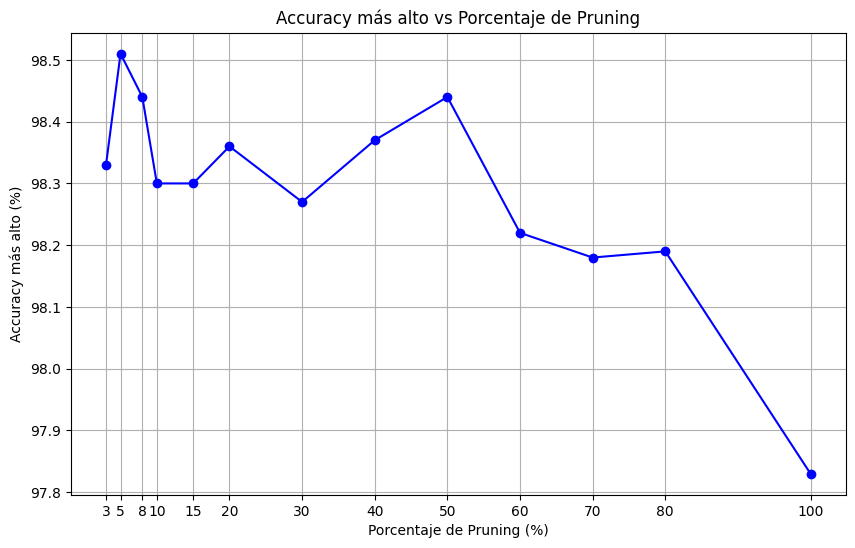

In [16]:
# Función para obtener la mejor accuracy de cada porcentaje de pruning
def extract_best_accuracies(results):
    best_accuracies = []
    pruning_percentages = []
    for percentage, data in results.items():
        pruning_percentages.append(percentage)
        best_accuracy = max(data["accuracies"])  # Mejor accuracy de todas las iteraciones para ese porcentaje
        best_accuracies.append(best_accuracy)
    return pruning_percentages, best_accuracies

# Extraer los datos
pruning_percentages, best_accuracies = extract_best_accuracies(results)

# Generar la gráfica
plt.figure(figsize=(10, 6))
plt.plot(pruning_percentages, [acc * 100 for acc in best_accuracies], marker='o', color='b')
plt.title('Accuracy más alto vs Porcentaje de Pruning')
plt.xlabel('Porcentaje de Pruning (%)')
plt.ylabel('Accuracy más alto (%)')
plt.grid(True)
plt.xticks(pruning_percentages)
plt.show()
